In [9]:
!pip install efficientnet


In [10]:
import cv2
import os
import numpy as np
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from efficientnet.keras import EfficientNetB3
from imblearn.over_sampling import SMOTE

In [11]:
# Set the data path and categories
data_path = '/kaggle/input/koa-1500/MedicalExpert-I'
categories = os.listdir(data_path)
labels = [i for i in range(len(categories))]

label_dict = dict(zip(categories, labels))

img_size = 156
data = []
label = []

# Load the images and labels
for category in categories:
    folder_path = os.path.join(data_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (img_size, img_size))
            data.append(resized)
            label.append(label_dict[category])
        except Exception as e:
            print('Exception:', e)

In [12]:
data = np.array(data) / 255.0
data_rgb = np.repeat(data[..., np.newaxis], 3, -1)
label = np.array(label)
new_label = np_utils.to_categorical(label)

# Perform SMOTE to balance the class distribution
smote = SMOTE(random_state=42)
data_reshaped = data_rgb.reshape(data_rgb.shape[0], -1)
data_smote, new_label_smote = smote.fit_resample(data_reshaped, new_label)
data_smote = data_smote.reshape(data_smote.shape[0], img_size, img_size, 3)

# Count the number of samples per class
unique_classes, class_counts = np.unique(np.argmax(new_label_smote, axis=1), return_counts=True)

# Print the class distribution
print("Class Distribution After SMOTE:")
for i, class_name in enumerate(categories):
    print(f"{class_name}: {class_counts[i]} samples")
    
# Split the data into train, test, and validation sets
x_train, x_test, y_train, y_test = train_test_split(data_smote, new_label_smote, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=42)

datagen_train = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

datagen_val = ImageDataGenerator()

train_generator = datagen_train.flow(x_train, y_train, batch_size=16)
val_generator = datagen_val.flow(x_val, y_val, batch_size=16)

Class Distribution After SMOTE:
1Doubtful: 514 samples
3Moderate: 514 samples
4Severe: 514 samples
2Mild: 514 samples
0Normal: 514 samples


# Before smote

In [16]:
# Calculate the class count
class_labels, class_count = np.unique(label, return_counts=True)

# Print the class count for each class
for label, count in zip(class_labels, class_count):
    print(f"Class '{label}' has {count} samples")


Class '0' has 477 samples
Class '1' has 221 samples
Class '2' has 206 samples
Class '3' has 232 samples
Class '4' has 514 samples


In [20]:
# Define the model architecture
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
# EfficientNet B3
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax

base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3), pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(len(categories), activation= 'softmax')
])


#model.add(base_model)
#model.add(GlobalAveragePooling2D())
#model.add(Dropout(0.5))
#model.add(Dense(len(categories), activation='softmax'))

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()
# Compile the model
#model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])
#model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b3 (Functional  (None, 1536)             10783528  
 )                                                               
                                                                 
 batch_normalization_5 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 256)               393472    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 11,184,429
Trainable params: 11,094,061


In [21]:
# Set up a checkpoint to save the best model
checkpoint = ModelCheckpoint('/kaggle/working/model2.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)


# Train the model
history = model.fit(train_generator,
                    epochs=90,
                    validation_data=val_generator,
                    callbacks=[checkpoint])

Epoch 1/90


2023-06-17 04:26:15.659845: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnet-b3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


113/113 [==============================] - ETA: 0s - loss: 9.2750 - accuracy: 0.3441
Epoch 1: val_accuracy improved from -inf to 0.27626, saving model to /kaggle/working/model2.h5
113/113 [==============================] - 96s 202ms/step - loss: 9.2750 - accuracy: 0.3441 - val_loss: 9.0833 - val_accuracy: 0.2763
Epoch 2/90
113/113 [==============================] - ETA: 0s - loss: 7.7512 - accuracy: 0.4786
Epoch 2: val_accuracy improved from 0.27626 to 0.41245, saving model to /kaggle/working/model2.h5
113/113 [==============================] - 19s 164ms/step - loss: 7.7512 - accuracy: 0.4786 - val_loss: 7.3866 - val_accuracy: 0.4125
Epoch 3/90
113/113 [==============================] - ETA: 0s - loss: 6.7087 - accuracy: 0.5281
Epoch 3: val_accuracy improved from 0.41245 to 0.55642, saving model to /kaggle/working/model2.h5
113/113 [==============================] - 19s 169ms/step - loss: 6.7087 - accuracy: 0.5281 - val_loss: 6.1364 - val_accuracy: 0.5564
Epoch 4/90
113/113 [==========

In [ ]:
'''batch_size = 40     # set batch size for training
epochs = 40         # number of all epochs in training
patience = 1 		    # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3 	# number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9 	  # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = 0.5 		    # factor to reduce lr by
ask_epoch = 5		    # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))'''

In [22]:
# Load the best weights
model.load_weights('/kaggle/working/model2.h5')

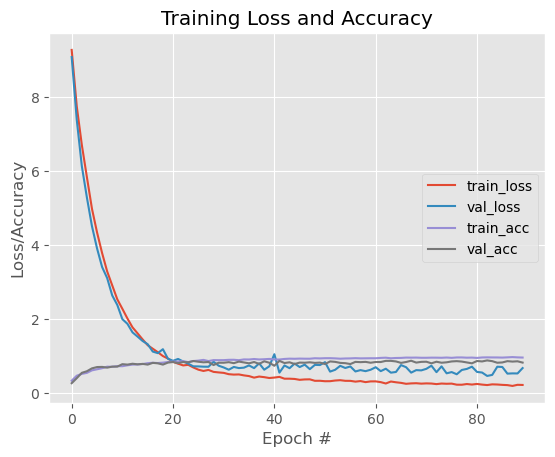

In [26]:
# Plot the training loss and accuracy
N = len(history.history['loss'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("EfficientNet_Model")



In [24]:
# Evaluate the model on the test set
val_loss, val_accuracy = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", val_loss)
print("Test accuracy:", val_accuracy)

Test loss: 0.6085208654403687
Test accuracy: 0.8501945734024048


17/17 [==============================] - 4s 58ms/step
              precision    recall  f1-score   support

           0       0.83      0.62      0.71       105
           1       1.00      0.89      0.94       100
           2       0.87      0.95      0.91       105
           3       0.75      0.86      0.80        95
           4       0.83      0.93      0.87       109

    accuracy                           0.85       514
   macro avg       0.86      0.85      0.85       514
weighted avg       0.86      0.85      0.85       514



<Figure size 640x480 with 0 Axes>

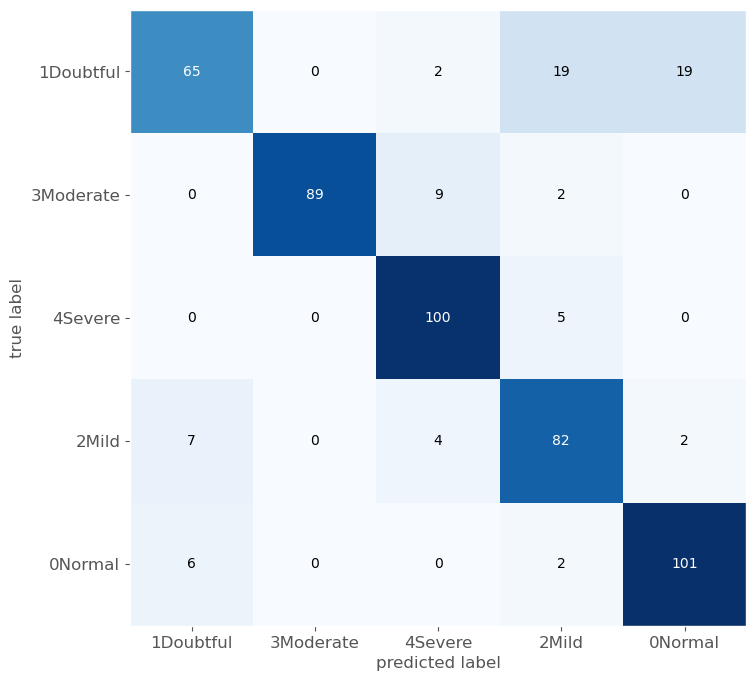

1/1 [==============================] - 0s 33ms/step
A.I predicts: 2Mild
Correct prediction for label 0 is 1Doubtful


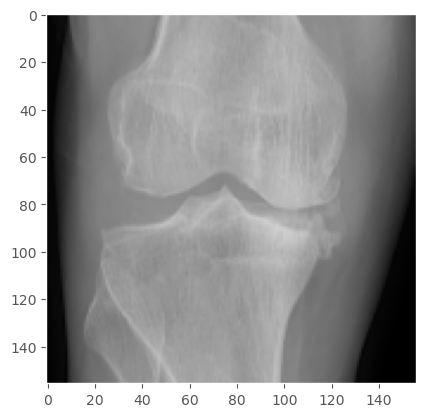

In [25]:
# Get the predictions for the test set
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=-1)

# Generate the classification report
report = classification_report(np.argmax(y_test, axis=1), predicted_labels)
print(report)

# Plot the confusion matrix
test_labels = np.argmax(y_test, axis=1)
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure()
plot_confusion_matrix(cm, figsize=(12, 8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(len(categories)), categories, fontsize=12)
plt.yticks(range(len(categories)), categories, fontsize=12)
plt.show()

# Select a single image from the test set for prediction
X = 32
img_single = x_test[X]
img_single = cv2.resize(img_single, (img_size, img_size))
img_single = np.expand_dims(img_single, 0)

# Make prediction on the single image
predictions_single = model.predict(img_single)
print('A.I predicts:', categories[np.argmax(predictions_single)])
print("Correct prediction for label", np.argmax(y_test[X]), 'is', categories[np.argmax(y_test[X])])

# Display the single image
plt.imshow(np.squeeze(img_single))
plt.grid(False)
plt.show()
